In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from utils import plot_images


## Reference Pepper MNIST sample 

We define the reference sample as binarized MNIST with threshold of 0.5 

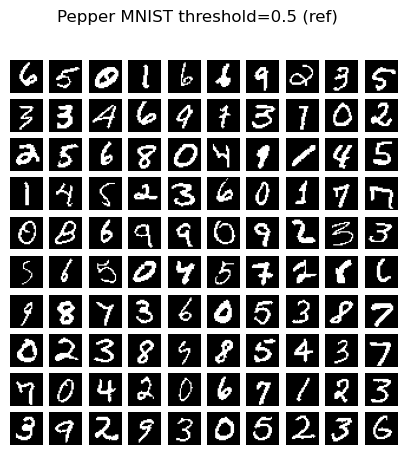

In [2]:
#...Retrieve 100 samples from training sample

from datasets import load_pepper_mnist

mnist_reference = load_pepper_mnist() 
loader_reference = DataLoader(mnist_reference, batch_size=100, shuffle=True)
images_reference, _ = next(iter(loader_reference))

plot_images(images_reference, "Pepper MNIST threshold=0.5 (ref)", figsize=(5, 5))

## Perturbed Pepper MNIST 

We now define the following perturbations of peppered MNIST:
- Pepper MNIST with binarizing thresholds different than 0.5 
- Gaussian noise 
- Gaussian Blurr
- Swirl deformation

We will later compute the FID between these datasets and the reference Pepper MNIST threshold=0.5 

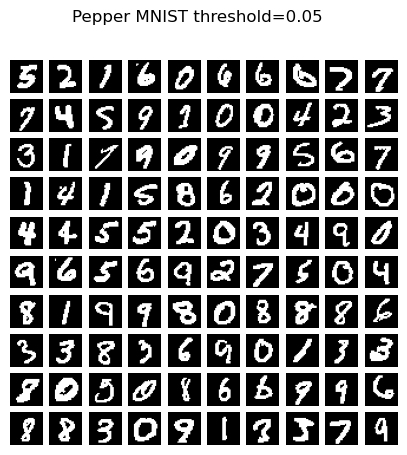

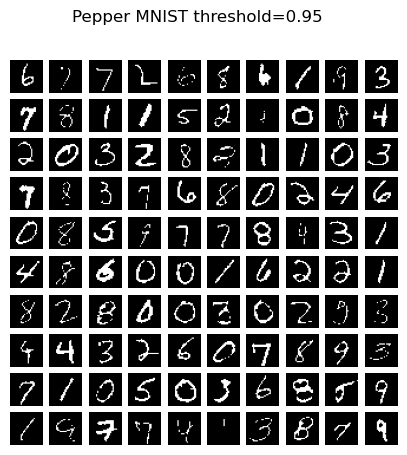

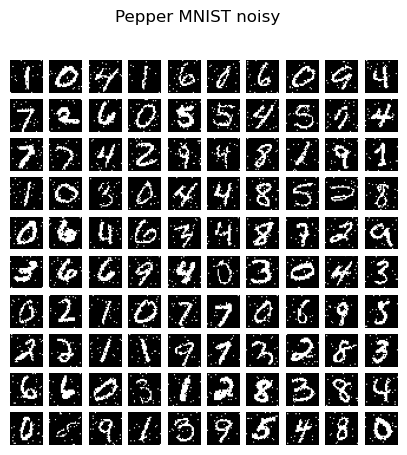

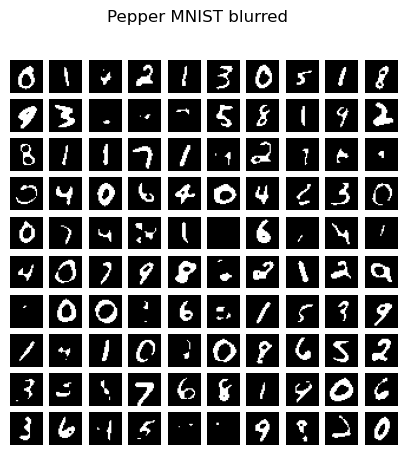

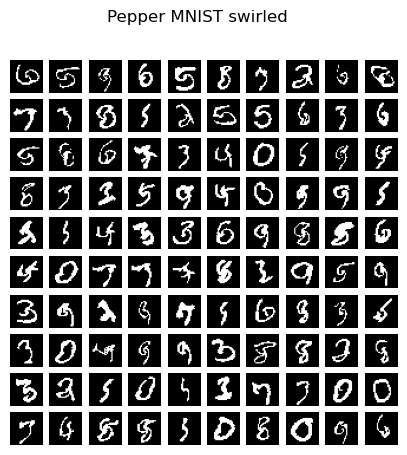

In [4]:
from datasets import load_noisy_pepper_mnist, load_blurred_pepper_mnist, load_swirled_pepper_mnist

mnist_threshold_1 = load_pepper_mnist(threshold=0.05)  
loader_threshold_1  = DataLoader(mnist_threshold_1, batch_size=100, shuffle=True)
images_threshold_1 , _ = next(iter(loader_threshold_1))

mnist_threshold_2 = load_pepper_mnist(threshold=0.95)  
loader_threshold_2  = DataLoader(mnist_threshold_2, batch_size=100, shuffle=True)
images_threshold_2 , _ = next(iter(loader_threshold_2))

mnist_noise = load_noisy_pepper_mnist(sigma=0.25)  
loader_noise  = DataLoader(mnist_noise, batch_size=100, shuffle=True)
images_noise , _ = next(iter(loader_noise ))

mnist_blurred = load_blurred_pepper_mnist(kernel_size=7, sigma=1.5) 
loader_blurred  = DataLoader(mnist_blurred, batch_size=100, shuffle=True)
images_blurred , _ = next(iter(loader_blurred ))

mnist_swirl = load_swirled_pepper_mnist(strength=3, radius=20)  
loader_swirl = DataLoader(mnist_swirl, batch_size=100, shuffle=True)
images_swirl, _ = next(iter(loader_swirl))

#...Plot the original and modified images
plot_images(images_threshold_1 , "Pepper MNIST threshold=0.05", figsize=(5, 5))
plot_images(images_threshold_2 , "Pepper MNIST threshold=0.95", figsize=(5, 5))
plot_images(images_noise , "Pepper MNIST noisy", figsize=(5, 5))
plot_images(images_blurred  , "Pepper MNIST blurred", figsize=(5, 5))
plot_images(images_swirl  , "Pepper MNIST swirled", figsize=(5, 5))

## Classifier for MNIST
We now train a classifier on the Reference Pepper MNIST data. This will be used later to compute the FID

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm

from fid import SimpleCNN

epochs = 10
model = SimpleCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Train the model
for epoch in tqdm.tqdm(range(1, epochs), desc="Epochs"):
    for batch_idx, (data, target) in enumerate(loader_reference):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

torch.save(model.state_dict(), 'mnist_cnn.pth')


Epochs: 100%|██████████| 9/9 [00:57<00:00,  6.43s/it]


We test the accuracy of the MNIST Classifier

In [6]:
from utils import get_accuracy_confusion_matrix

model.eval()

# Load MNIST test dataset
test_dataset_ref = load_pepper_mnist(0.5, train=False)
test_loader_ref = DataLoader(test_dataset_ref, batch_size=1000, shuffle=False)

# Test the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
get_accuracy_confusion_matrix(model, device, test_loader_ref)


Test set: Average loss: 0.0402, Accuracy: 9863/10000 (99%)

Confusion Matrix:
 [[ 970    0    1    0    1    3    2    2    1    0]
 [   0 1130    1    0    1    1    1    0    1    0]
 [   0    1 1020    3    1    0    0    7    0    0]
 [   0    0    1  999    0    8    0    2    0    0]
 [   0    2    1    0  975    0    1    0    0    3]
 [   1    0    0    3    0  884    2    1    1    0]
 [   1    4    0    0    4   10  939    0    0    0]
 [   0    5    2    1    0    0    0 1020    0    0]
 [   1    2    2    4    1    7    0    2  949    6]
 [   0    4    0    2   11    3    0   11    1  977]]


## FID computations

### 1. Binarizing Threshold

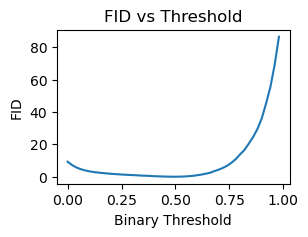

In [9]:
import numpy as np
from fid import compute_FID

fid = compute_FID(model, perturbation='threshold', values=np.arange(0.0, 1, 0.02))

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid.keys(), fid.values())
plt.ylabel('FID')
plt.xlabel('Binary Threshold')
plt.show()

### 2. Gaussian noise

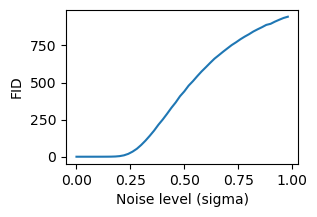

In [13]:
import numpy as np
from fid import compute_FID

fid = compute_FID(model, perturbation='noise', values=np.arange(0.0, 1, 0.02))

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid.keys(), fid.values())
plt.ylabel('FID')
plt.xlabel('Noise level (sigma)')
plt.show()

### 3. Gaussian blur

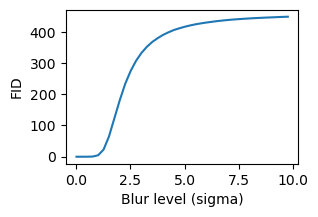

In [7]:
import numpy as np
from fid import compute_FID

fid = compute_FID(model, perturbation='blur', values=np.arange(0.01, 10, 0.25))

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid.keys(), fid.values())
plt.ylabel('FID')
plt.xlabel('Blur level (sigma)')
plt.show()

### 4. Swirl deformation

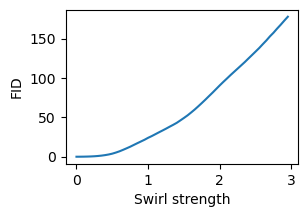

In [7]:
import numpy as np
from fid import compute_FID

fid = compute_FID(model, perturbation='swirl', values=np.arange(0, 3, 0.05))

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid.keys(), fid.values())
plt.ylabel('FID')
plt.xlabel('Swirl strength')
plt.show()